In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
class SimpleSignal (torch.utils.data.Dataset):
    def __init__(self):
        super(SimpleSignal, self).__init__()
        self.data, self.labels = self.generate_data()
        self.train_ix, self.test_ix = self.get_ix_splits()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.data)
    
    def get_ix_splits(self):
        split_props = [0.8, 0.1, 0.1] # train/ validation / test split proportions
        indices = range(len(self.data))
        split_points = [int(len(self.data) * i) for i in split_props]
        
        train_ix = np.random.choice(indices, 
                                   split_points[0],
                                   replace = False)
        test_ix = np.random.choice(list(set(indices) - set(train_ix)),
                                  split_points[1],
                                  replace = False)
    
        return train_ix, test_ix
        
    def generate_data(self):
        
        data = []
        labels = []
        data1 = open('ItalyPowerDemand_TRAIN')
        lines1 = data1.readlines()
        data2 = open('ItalyPowerDemand_TEST')
        lines2 = data2.readlines()
        
        # EXTRACTING THE LABELS
        
        firstNumber1 = [i[0] for i in lines1]
        labels.append(firstNumber1)
        firstNumber2 = [i[0] for i in lines2]
        labels.append(firstNumber2)
        
        # adding the label lists from both training and testing 
        labels = labels[0] + labels[1]
        labels = list(map(int, labels))
        
        # convert from 1 to 0, from 2 to 1
        for i in range(len(labels)):
            if labels[i] == 1:
                labels[i] = 0
            else:
                labels[i] = 1
        
        
        # EXTRACTING THE DATA
        lines = lines1 + lines2
        
        # i is the line #
        for i in range(len(lines)):
            line = np.asarray(lines[i].split(','))
            tempData = []
            
            for j in range(1, len(line)):
                elem = float(line[j])
                tempData.append(elem)
            
            data.append(tempData)
            
        '''
        print("Raw data: ")
        for i in lines:
            print(i)
        print("Labels: ", labels)
        print()
        print("Data: ", data)
        '''
        
        dataTensor = torch.tensor(data, dtype = torch.float).unsqueeze(2)
        labelsTensor= torch.tensor(labels, dtype = torch.long)
        
        print(np.shape(dataTensor))
        print(np.shape(labelsTensor))
        
        return dataTensor, labelsTensor
    

In [3]:
# --- Model architecture and training ---

HIDDEN_DIMENSION = 20
N_LAYERS = 3
BATCH_SIZE = 10
N_EPOCHS = 28
LEARNING_RATE = [.001, .005, .01]

# --- Data generation parameters ---

N_FEATURES = 1
N_CLASSES = 2

# training set into 10 batches 
# each has 80 objects

# --- create the dataset ---
data = SimpleSignal()


ones = 0

for i in range(len(data)):
    # print
    if (data.labels[i] == 1):
        ones += 1
        
zeros = len(data) - ones
        
print('proportion of ones: ', ones / len(data))
print('proportion of zeroes: ', zeros / len(data))


torch.Size([1096, 24, 1])
torch.Size([1096])
proportion of ones:  0.5009124087591241
proportion of zeroes:  0.4990875912408759


In [4]:
# --- define the data loaders ---
train_sampler = SubsetRandomSampler(data.train_ix) # Random sampler for training indices
test_sampler = SubsetRandomSampler(data.test_ix) # Random sampler for testing indices

# drop_last = True to drop the last incomplete batch, if the dataset size is not
# divisible by the batch size
train_loader = torch.utils.data.DataLoader(dataset=data,
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                           shuffle=False, drop_last = True)

test_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=BATCH_SIZE, 
                                          sampler=test_sampler,
                                          shuffle=False, drop_last = True)

# --- define your model here ---
class RNN(nn.Module):
    def __init__(self, HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE):
        super(RNN, self).__init__()
        self.N_LAYERS = N_LAYERS
        self.BATCH_SIZE = BATCH_SIZE
        self.HIDDEN_DIMENSION = HIDDEN_DIMENSION
        self.N_CLASSES = N_CLASSES
        
        # --- define mappings here ---
        self.lstm = torch.nn.LSTM(N_FEATURES, HIDDEN_DIMENSION, N_LAYERS)       #sets up initial weight matrices
        self.out = torch.nn.Linear(HIDDEN_DIMENSION, N_CLASSES)
        #nonlinear part - tells probabilites
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, X):  #X is input data - tensor shape = (batch size, input dimension)
        # --- define forward pass here ---
        #initialize hidden state - need to do this because this is an RNN/LSTM (you use torch.nn.LSTM above)
        state = (torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION), # h_0 initial hidden state
                 torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION)) # c_0 initial cell state
        X = torch.transpose(X, 0, 1)  #should have shape timesteps, batch_size, num features
        
        hidden, state = self.lstm(X, state)   #X is timeseries, shape is (timesteps, batch size)
        #hidden = h_t = hidden cell sate after w1 weight matrix (self.LSTM has been applied to the current cell) = this is actually vector containing all h_t's for each cell
        #state = (h_n, c_n) = h_n is hidden state that depends on all previous cells, c_n is cell state that depends on all previous cells
        output = self.out(hidden[-1])   #cell's hidden state gets passed thru w2 (out) weight matrix to produce output
        prediction = self.softmax(output)
        return prediction

In [6]:
loss_dif_lr = []
accuracy_dif_lr = []

# loop over the number of layers

# looping over the learning rate
for i_lr in range(len(LEARNING_RATE)):
    
    
    # --- initialize the model and the optimizer ---
    model = RNN(HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE)
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE[i_lr]) 
    # Using the Adam optimizer - don't worry about the details, it's going to update the network's weights.
    criterion = torch.nn.CrossEntropyLoss()   #definig loss function

    # --- training the model ---
    
    loss_vector_training=[]
    accuracy_vector_training=[]
    for epoch in range(N_EPOCHS):
        loss_sum = 0
        
        predictions_sum = 0
        labels_sum = 0
        for i, (time_series, labels) in enumerate(train_loader): # Iterate through the training batches
            
            # --- Forward pass ---
            predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)
        
            #zero gradients, can also do model.zero_grad() in this case
            optimizer.zero_grad()   
        
            for i in range(10):
                predict = predictions[i,1]
                if predict <=.5:
                    estimate=0
                else:
                    estimate=1
                if estimate==labels[i]:
                    predictions_sum += 1
                labels_sum += 1
            
            # --- Compute gradients and update weights ---
            # criterion is the cross entropy loss function
            loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
            loss_sum += loss.item()
            
            loss.backward(retain_graph = True)
            optimizer.step()  #updates parameters using Adam alg rather than grad descent
            #if (i+1) % 1 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, i+1, len(train_loader), loss.item()))
        accuracy = predictions_sum/labels_sum
        loss_total = loss_sum/ 87
        accuracy_vector_training.append(accuracy)
        loss_vector_training.append(loss_total)
        print('accuracy: ', accuracy)
        print ('Loss for each Epoch:','Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, loss_total))
    loss_dif_lr.append(loss_vector_training)
    accuracy_dif_lr.append(accuracy_vector_training)

accuracy:  0.5183908045977011
Loss for each Epoch: Epoch [1/28], Loss: 0.6901
accuracy:  0.8528735632183908
Loss for each Epoch: Epoch [2/28], Loss: 0.5070
accuracy:  0.9333333333333333
Loss for each Epoch: Epoch [3/28], Loss: 0.3864
accuracy:  0.9413793103448276
Loss for each Epoch: Epoch [4/28], Loss: 0.3771
accuracy:  0.9379310344827586
Loss for each Epoch: Epoch [5/28], Loss: 0.3715
accuracy:  0.9551724137931035
Loss for each Epoch: Epoch [6/28], Loss: 0.3595
accuracy:  0.9448275862068966
Loss for each Epoch: Epoch [7/28], Loss: 0.3657
accuracy:  0.9390804597701149
Loss for each Epoch: Epoch [8/28], Loss: 0.3714
accuracy:  0.960919540229885
Loss for each Epoch: Epoch [9/28], Loss: 0.3549
accuracy:  0.9551724137931035
Loss for each Epoch: Epoch [10/28], Loss: 0.3573
accuracy:  0.9586206896551724
Loss for each Epoch: Epoch [11/28], Loss: 0.3532
accuracy:  0.957471264367816
Loss for each Epoch: Epoch [12/28], Loss: 0.3564
accuracy:  0.960919540229885
Loss for each Epoch: Epoch [13/28]

In [7]:
#validation - no data for this, so skipping this step

#testing
loss_testing_dif_lr = []
accuracy_testing_dif_lr = []

loss_vector_testing=[]
accuracy_vector_testing=[]
for i, (time_series, labels) in enumerate(test_loader): # Iterate through the testing set, 10 timeseries in 10 batches (100 timeseries total)
        predictions_sum = 0
        labels_sum = 0
        loss_sum = 0
        predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

        for i in range(10):
            predict = predictions[i,1]
            if predict <=.5:
                estimate=0
            else:
                estimate=1
            if estimate==labels[i]:
                predictions_sum += 1
            labels_sum += 1
        loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
        loss_sum += loss.item()
        accuracy = predictions_sum/labels_sum
        loss_vector_testing.append(loss_sum)
        accuracy_vector_testing.append(accuracy)
        print('accuracy: ', accuracy)
        print('loss: ', loss_sum)
loss_testing_dif_lr.append(loss_vector_testing)
accuracy_testing_dif_lr.append(accuracy_vector_testing)


accuracy:  0.9
loss:  0.41338473558425903
accuracy:  1.0
loss:  0.313326895236969
accuracy:  1.0
loss:  0.31331223249435425
accuracy:  0.9
loss:  0.4132300019264221
accuracy:  1.0
loss:  0.3133488595485687
accuracy:  1.0
loss:  0.3133237063884735
accuracy:  1.0
loss:  0.31484121084213257
accuracy:  1.0
loss:  0.3133407235145569
accuracy:  1.0
loss:  0.313368022441864
accuracy:  0.9
loss:  0.41328510642051697


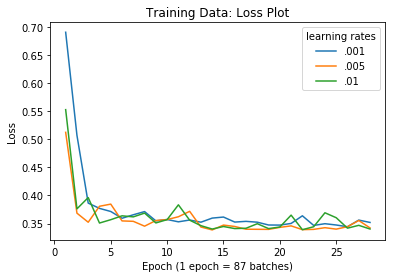

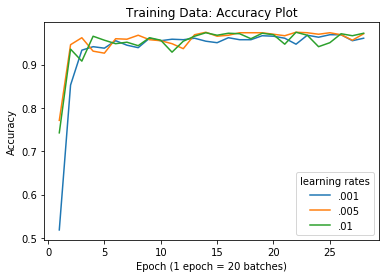

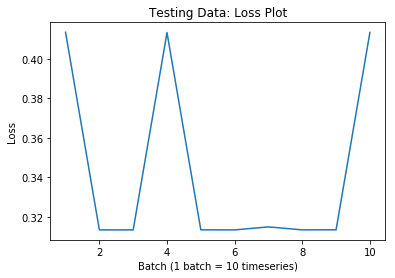

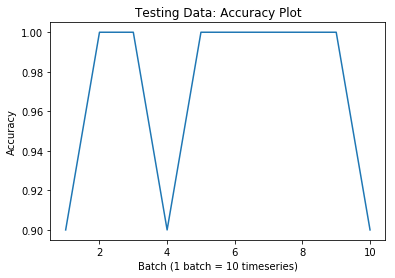

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

"""
tuples_vector = []
for hd in HIDDEN_DIMENSION:
    for lr in LEARNING_RATE:
        tuples_vector.append( hd, lr)
"""

epochs_vector = [i for i in range(1, N_EPOCHS + 1)]

# this is doing the same thing as 
# plt.plot(epochs_vector, accuracy_dif_lr[0])
# plt.plot(epochs_vector, accuracy_dif_lr[1])
# plt.plot(epochs_vector, accuracy_dif_lr[2])
for YAxis in loss_dif_lr:
    plt.plot(epochs_vector, YAxis)
plt.legend(['.001', '.005', '.01'], loc='upper right', title='learning rates')
plt.title('Training Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 87 batches)')
plt.show();

for YAxis in accuracy_dif_lr:
    plt.plot(epochs_vector, YAxis)
plt.legend(['.001', '.005','.01'], loc='lower right', title="learning rates")
plt.title('Training Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch (1 epoch = 20 batches)')
plt.show();

batch_vector = [i for i in range(1, 11)]
plt.plot(batch_vector, loss_vector_testing)
plt.title('Testing Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .3, .646])
plt.show();

plt.plot(batch_vector, accuracy_vector_testing)
plt.title('Testing Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .654, 1.022])
plt.show();